# Project Overview

The goal: 

Detect what is truthful versus deceptive in terms of hotel reviews. 

## 1. Load Packages + Set Up

In [1]:
import pandas as pd
import numpy as np 
import warnings
import sklearn as sk
import seaborn as sns; sns.set(color_codes=True)


import gensim as gs
import re
from collections import defaultdict
from sklearn.lda import LDA


warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
%matplotlib inline

from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

C:\Users\Chris\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


## Load Packages from previous NLP work

In [2]:
# 2. Prep Data
def prep_nlp(data_to_prep, stop_words_in, symbols_to_remove):
    # lower case it
    clean = list(data_to_prep.str.lower())
    # this will tokenize
    clean = [[word for word in document.split()] for document in clean]
    words_to_remove = '|'.join(stop_words_in)
    clean = [[re.sub(symbols_to_remove,'',word) for word in text] for text in clean]
    clean = [[re.sub(words_to_remove,'',word) for word in text] for text in clean]
    return clean

def build_model(train_data, topic_n):
    frequency = defaultdict(int)
    for text in train_data:
        for token in text:
            frequency[token] += 1
    # get freq > 1
    word_freq_1plus = [[x for x in words if frequency[x] > 1] for words in train_data]
    # Create dictionary
    dictionary = gs.corpora.Dictionary(word_freq_1plus)
    # Create Corpus
    corpus = [dictionary.doc2bow(text) for text in train_data]
    # corpus to tfidf
    tfidf = gs.models.TfidfModel(corpus) 
    corp_tf = tfidf[corpus] 
    # Unsupervised Component. Reduce space into 300 topics. 
    topic_n = topic_n
    lsi = gs.models.LsiModel(corp_tf, id2word=dictionary, num_topics = topic_n)
    corp_topics = lsi[corp_tf] 
    return corp_topics, dictionary, tfidf, lsi  

def train_model(topic_vec, column, target):
    x = pd.DataFrame([dict(row) for row in topic_vec[0]])
    y = (column == target).astype(int) 
    lda = LDA()
    mask = np.array([~np.isnan(row).any() for row in x.values])
    x_masked = x[mask]
    y_masked = y[mask]
    lda = lda.fit(x_masked,y_masked)
    return lda,x_masked,y_masked, topic_vec[1],topic_vec[2], topic_vec[3]

def predict_unseen(content_in, outcome_in, stop_words_in, trained_model_in, symbols_to_remove, target):

    dictionary_in = trained_model_in[3]
    tfidf_in = trained_model_in[4]
    lsi_in = trained_model_in[5]
    lda_in = trained_model_in[0]
    new_doc_in_content = pd.Series(content_in)
    new_doc_in_outcome = pd.Series(outcome_in)
    
    query = prep_nlp(new_doc_in_content, stop_words_in, symbols_to_remove)
    query_bow = [dictionary_in.doc2bow(corp) for corp in query]
    query_tf = tfidf_in[query_bow] 
    
    x_2 = pd.DataFrame([dict(tf) for tf in lsi_in[query_tf]])
    mask = np.array([~np.isnan(row).any() for row in x_2.values])
    x_2masked = x_2[mask]
    y_2 = (new_doc_in_outcome == target).astype(int) 
    
    y_2masked = np.array(y_2[mask])
    x_2masked = lda_in.predict(x_2masked)
    
    return x_2masked,y_2masked

def performance(result_x, result_y):
    actual_positive = result_y == 1
    actual_negative = result_y ==0
    true_positives = result_x[actual_positive] == 1
    false_positives = result_x[actual_negative] == 1
    true_negatives = result_x[actual_negative] == 0
    false_negatives = result_x[actual_positive] == 0
    #A. Accuracy = (TP + TN)/(TP + TN + FP + FN)
    #B. Precision = TP/(TP + FP)
    #C. Recall = TP/(TP + FN)
    accuracy = sum((result_x == result_y))/len(result_y)
    precision = sum(true_positives) / (sum(true_positives) + sum(false_positives))
    recall = sum(true_positives) / (sum(true_positives) + sum(false_negatives))
    return [accuracy, precision, recall, len(result_x)]

## 2. Read Data, Describe
- Look at first five rows, then last five rows


In [3]:
data_in = pd.read_csv('deceptive-opinion.csv')
display(data_in.head())
display(data_in.tail())

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


,deceptive,hotel,polarity,source,text
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama..."


## 3. Explore Data
Questions:
1. Are there substantive differences between hotels?
    - Length? 
2. Is there a differnce the type of words across hotels?

In [4]:
data_in.pivot_table(
    columns=['deceptive','polarity'],
    index = ['hotel'],
    aggfunc = len).fillna(0)

source                                 text           \
deceptive        deceptive          truthful          deceptive            
polarity          negative positive negative positive  negative positive   
hotel                                                                      
affinia                 20       20       20       20        20       20   
allegro                 20       20       20       20        20       20   
amalfi                  20       20       20       20        20       20   
ambassador              20       20       20       20        20       20   
conrad                  20       20       20       20        20       20   
fairmont                20       20       20       20        20       20   
hardrock                20       20       20       20        20       20   
hilton                  20       20       20       20        20       20   
homewood                20       20       20       20        20       20   
hyatt                   20       20       20       20        20       20   
intercontinental        20       20       20       20        20       20   
james                   20       20       20       20        20       20   
knickerbocker           20       20       20       20        20       20   
monaco                  20       20       20       20        20       20   
omni                    20       20       20       20        20       20   
palmer                  20       20       20       20        20       20   
sheraton                20       20       20       20        20       20   
sofitel                 20       20       20       20        20       20   
swissotel               20       20       20       20        20       20   
talbott                 20       20       20       20        20       20   

                                    
deceptive        truthful           
polarity         negative positive  
hotel                               
affinia                20       20  
allegro                20       20  
amalfi                 20       20  
ambassador             20       20  
conrad                 20       20  
fairmont               20       20  
hardrock               20       20  
hilton                 20       20  
homewood               20       20  
hyatt                  20       20  
intercontinental       20       20  
james                  20       20  
knickerbocker          20       20  
monaco                 20       20  
omni                   20       20  
palmer                 20       20  
sheraton               20       20  
sofitel                20       20  
swissotel              20       20  
talbott                20       20

In [5]:
def mean_len(group, mean = True):
    if mean == True:
        return np.mean(group.text.str.len())
    else:
        return group.text.str.len()


### 3a. Deceptive vs Truthful Review Length


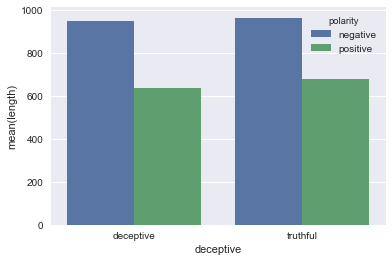

In [266]:
grouped_data = data_in.groupby(['deceptive','polarity']).apply(mean_len, mean = True)
grouped_hotel= pd.DataFrame(grouped_data)
grouped_hotel = grouped_hotel.reset_index()
grouped_hotel.columns.values[2] = 'length'
_ = sns.barplot(x = 'deceptive', y = 'length', hue = 'polarity', data = grouped_hotel)

#### Run Test on Deceptive and Truthful Length
Results below show that there is not a stat sig difference. 

In [269]:
from scipy.stats import ttest_ind
pd.set_option('display.float_format', lambda x: '%.3f' % x)

positive = data_in[data_in.deceptive == 'deceptive'].text.str.len()
negative = data_in[data_in.deceptive == 'truthful'].text.str.len()

result = ttest_ind(positive,negative)
result

Ttest_indResult(statistic=-1.2520931090803307, pvalue=0.21071916472895064)

### 3b.Positive and Negative Polarity Review Length

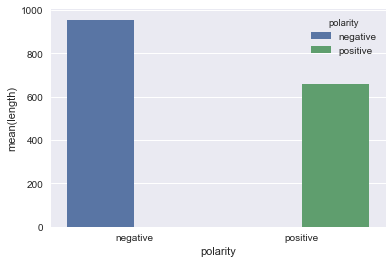

In [272]:
grouped_data = data_in.groupby('polarity').apply(mean_len, mean = True)
grouped_polarity= pd.DataFrame(grouped_data)
grouped_polarity = grouped_polarity.reset_index()
grouped_polarity.columns.values[1] = 'length'
_ = sns.barplot(x = 'polarity', y = 'length', hue = 'polarity', data = grouped_polarity)

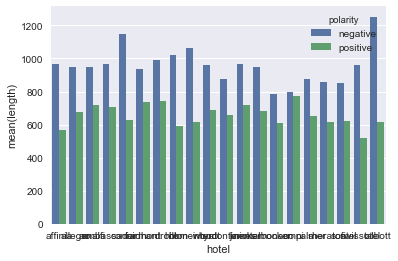

In [270]:
grouped_data = data_in.groupby(['hotel','polarity']).apply(mean_len, mean = True)
grouped_hotel= pd.DataFrame(grouped_data)
grouped_hotel = grouped_hotel.reset_index()
grouped_hotel.columns.values[2] = 'length'
_ = sns.barplot(x = 'hotel', y = 'length', hue = 'polarity', data = grouped_hotel)

#### Run Test on Positive and Negative Polarity
results below show that there is a stat sig difference, and that positive values are indeed shorter in length.

In [271]:
from scipy.stats import ttest_ind
pd.set_option('display.float_format', lambda x: '%.3f' % x)

positive = data_in[data_in.polarity == 'positive'].text.str.len()
negative = data_in[data_in.polarity == 'negative'].text.str.len()

result = ttest_ind(positive,negative)
result

Ttest_indResult(statistic=-13.507204854821099, pvalue=1.8968798894685588e-39)

### 3c. Are words different? Between Deceptive vs Truthful?

Seems that the top words are similar. But, lower frequency words have more typos when it comes to truthful reviews.

In [273]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def word_freq(text_in):
    text_in = text_in.str.lower().str.split()
    text_in = text_in.apply(lambda x: [item for item in x if item not in stop])
    text_in = [[re.sub(symbol_remover,'',word) for word in text] for text in text_in]
    frequency = defaultdict(int)
    for text in text_in:
        for token in text:
            frequency[token] += 1

    result = pd.DataFrame.from_dict(frequency,orient='index').reset_index()
    result.columns.values[1] = 'freq'
    
    return result.sort_values('freq',ascending = 0)
deceptive_word_freq = word_freq(data_in[data_in.deceptive == 'deceptive'].text)
truthful_word_freq = word_freq(data_in[data_in.deceptive == 'truthful'].text)

display(deceptive_word_freq[deceptive_word_freq.freq > 1].head(25))
display(deceptive_word_freq[deceptive_word_freq.freq > 1].tail(25))
display(truthful_word_freq[truthful_word_freq.freq >1].head(25))
display(truthful_word_freq[truthful_word_freq.freq >1].tail(25))

,index,freq
85,hotel,1804
22,room,1387
3,chicago,1015
92,stay,702
54,would,473
8,service,428
108,staff,396
98,one,350
156,rooms,349
43,like,328


,index,freq
2966,pastry,2
5093,gain,2
6587,cancelled,2
634,receptionists,2
4521,ground,2
5337,freshener,2
5042,turd,2
507,soaking,2
4539,dismay,2
5915,british,2


,index,freq
101,hotel,1477
13,room,1377
69,,622
241,stay,597
64,great,541
56,chicago,483
52,would,443
174,staff,437
36,service,377
1,one,353


,index,freq
6918,pointed,2
6968,repaired,2
2157,receptions,2
2772,jobs,2
6903,cockroach,2
7248,marriotts,2
2832,hate,2
3376,extend,2
1757,proved,2
3450,valentines,2


### 4. Create Train, validate, test Data

In [253]:
train, validate, test = np.split(data_in.sample(frac=1,random_state=100), [int(.6*len(data_in)), int(.8*len(data_in))])

### 5. Create Baseline Model

In [250]:
# set stop words / symbols to remove
stopwords_remove = ''
symbols_remove = ''

In [254]:
# prepare data, remove stop words list and symbols list
baseline_prepped = prep_nlp(data_to_prep=train.text, stop_words_in=stopwords_remove, symbols_to_remove=symbols_remove)

# run latent semantic indexing with 300 topics
baseline_build = build_model(train_data=baseline_prepped, topic_n=300)

# predict with lda
baseline_trained = train_model(topic_vec=baseline_build,column=train.deceptive, target='deceptive')
performance_on_train = performance(
    result_x=baseline_trained[0].predict(baseline_trained[1]),
    result_y=np.array(baseline_trained[2]))

In [258]:
# run model on validate data
predicted_validate = predict_unseen(
    content_in = validate.text,
    outcome_in = validate.deceptive,
    stop_words_in = stopwords_remove,
    symbols_to_remove = symbols_remove,
    trained_model_in = baseline_trained,
    target = 'deceptive')

# run model on validate data


predicted_test = predict_unseen(
    content_in = test.text,
    outcome_in = test.deceptive,
    stop_words_in = stopwords_remove,
    symbols_to_remove = symbols_remove,
    trained_model_in = baseline_trained,
    target = 'deceptive')

performance_on_test = performance(
    result_x=predicted_test[0],
    result_y=predicted_test[1])

# get performance
performance_on_validate = performance(
    result_x=predicted_validate[0],
    result_y=predicted_validate[1])

# show results in a table
results_out = pd.DataFrame({
    'Train':performance_on_train,
    'Validate':performance_on_validate,
    'test':performance_on_test
}).set_index(
    [['Accuracy','Precision','Recall','N Size'],
     ['% Deceptive / Genuine Correct','% Predicted Spam Actually Deceptive','% Deceptive Detected','']])
results_out

,,Train,Validate,test
Accuracy,% Deceptive / Genuine Correct,0.954,0.863,0.869
Precision,% Predicted Spam Actually Deceptive,0.948,0.847,0.900
Recall,% Deceptive Detected,0.960,0.869,0.847
N Size,,960.000,320.000,320.000
